In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
s = pd.read_csv("powerconsumption.csv")
s = s[["PowerConsumption_Zone1"]]
s = s.to_numpy().flatten()
z = []

sumStep = 6 #6 is for every hour, 3 is for every 30 minutes

for i in range(0, len(s) - (sumStep-1), sumStep):
  z.append(int(sum(s[i:i+sumStep])))

In [ ]:
df = pd.read_csv("powerconsumption.csv")
df = df[['Datetime', 'PowerConsumption_Zone1']]
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace = True)
df.rename(columns={"PowerConsumption_Zone1": "Power Cons."}, inplace = True)
df[["Power Cons."]] = df[["Power Cons."]].astype(int)
df = df[0::sumStep]
df['Power Cons.'] = z
temp = df[7999:]
df = df[:8000]

<ipython-input-81-afb283652b9a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Power Cons.'] = z


In [ ]:
df

,Power Cons.
Datetime,
2017-01-01 00:00:00,175187
2017-01-01 01:00:00,147943
2017-01-01 02:00:00,132498
2017-01-01 03:00:00,124866
2017-01-01 04:00:00,122855
...,...
2017-12-01 03:00:00,129916
2017-12-01 04:00:00,128973
2017-12-01 05:00:00,129715


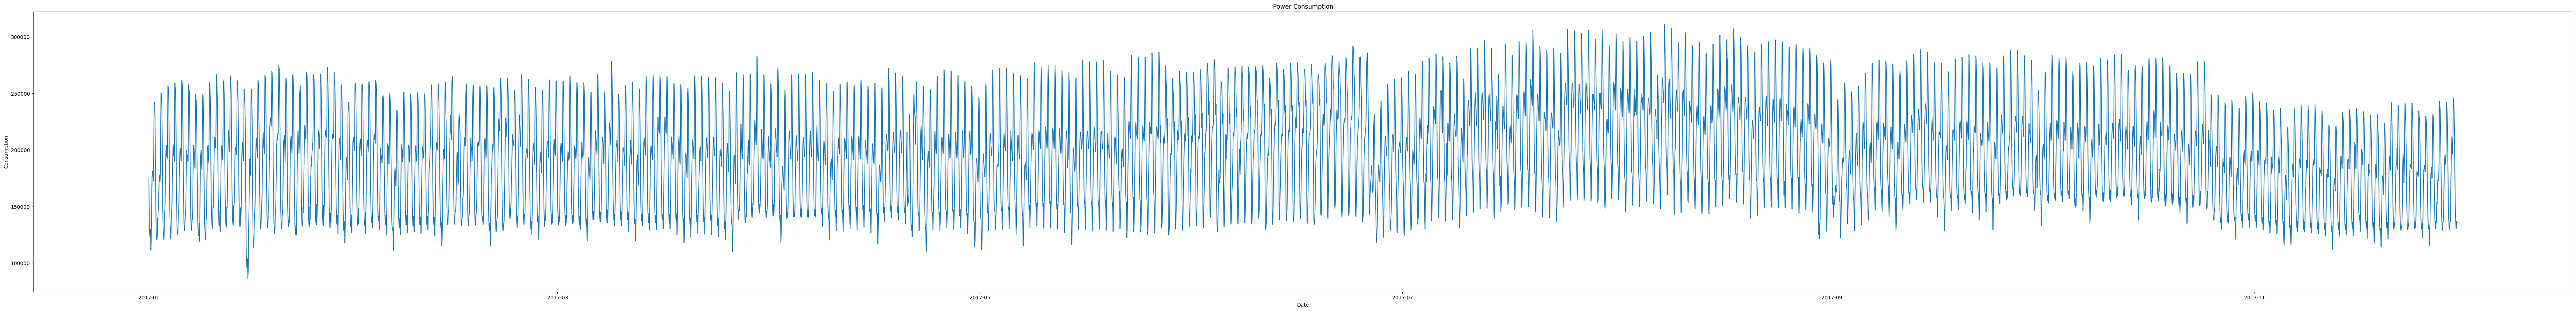

In [ ]:
plt.figure(figsize=(90, 10))
plt.plot(df)
plt.title('Power Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, 1)), Dense(1)
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint('model/')
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, callbacks=[mc])

Epoch 1/25
197/197 [==============================] - 19s 90ms/step - loss: 0.0395
Epoch 2/25
197/197 [==============================] - 17s 86ms/step - loss: 0.0095
Epoch 3/25
197/197 [==============================] - 18s 91ms/step - loss: 0.0047
Epoch 4/25
197/197 [==============================] - 17s 87ms/step - loss: 0.0030
Epoch 5/25
197/197 [==============================] - 16s 81ms/step - loss: 0.0029
Epoch 6/25
197/197 [==============================] - 15s 75ms/step - loss: 0.0024
Epoch 7/25
197/197 [==============================] - 15s 74ms/step - loss: 0.0021
Epoch 8/25
197/197 [==============================] - 14s 73ms/step - loss: 0.0020
Epoch 9/25
197/197 [==============================] - 15s 78ms/step - loss: 0.0019
Epoch 10/25
197/197 [==============================] - 13s 67ms/step - loss: 0.0018
Epoch 11/25
197/197 [==============================] - 13s 66ms/step - loss: 0.0018
Epoch 12/25
197/197 [==============================] - 13s 66ms/step - loss: 0.0018
E

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model/')

50/50 [==============================] - 0s 4ms/step


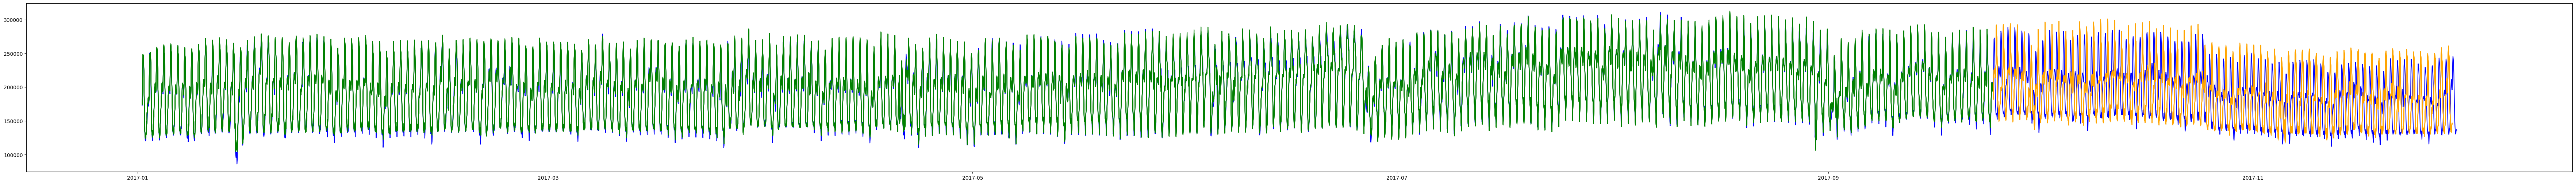

In [ ]:
#Make predictions
train_predictions = model1.predict(X_train)
test_predictions = model1.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(90, 6))

# Plot actual data
plt.plot(df.index[seq_length:], df['Power Cons.'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions',color='orange')

47/47 [==============================] - 1s 20ms/step


<Axes: >

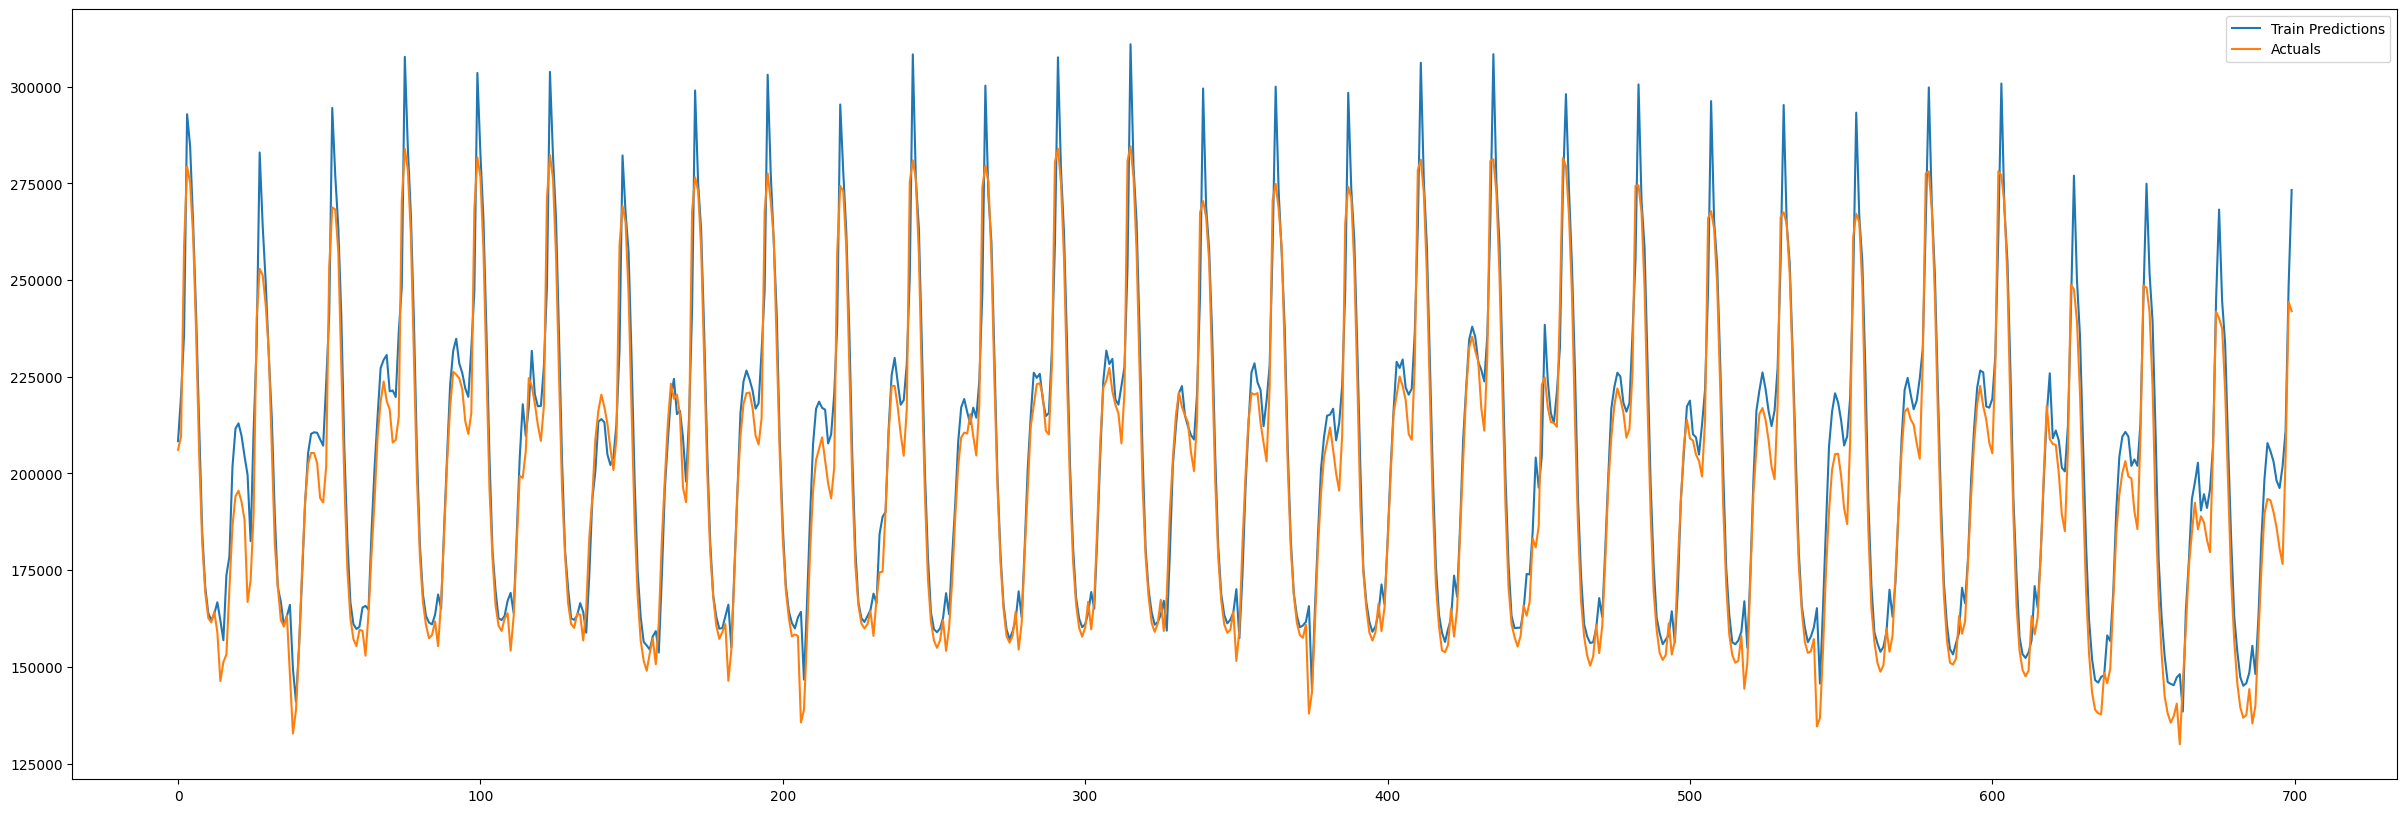

In [ ]:
train_predictions = model1.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions).flatten()
ActualData = scaler.inverse_transform(y_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':ActualData})
train_results[:700].plot(figsize=(30, 10))

In [ ]:
forecast_period = 24*7 #1 week
forecast = []

# Use the last sequence from the test data to make predictions
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Reshape the sequence to match the input shape of the model
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predict the next value
    next_prediction = model1.predict(current_sequence)[0][0]
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

forecast

1/1 [==============================] - 0s 44ms/step


array([[143627.17],
       [154646.  ],
       [167692.95],
       [179994.5 ],
       [188904.58],
       [194114.17],
       [195927.94],
       [194917.05],
       [195503.17],
       [203309.86],
       [217366.75],
       [229486.88],
       [234911.8 ],
       [233118.19],
       [224266.11],
       [209343.4 ],
       [192673.81],
       [177480.06],
       [165814.39],
       [158098.64],
       [153968.05],
       [152642.72],
       [152951.12],
       [152799.75],
       [152492.44],
       [154637.61],
       [160793.05],
       [170259.84],
       [179870.34],
       [187248.22],
       [190794.23],
       [190516.77],
       [191470.83],
       [200149.1 ],
       [216168.81],
       [230931.22],
       [238307.52],
       [236579.2 ],
       [226103.56],
       [209557.7 ],
       [191964.86],
       [176645.62],
       [165184.36],
       [157643.39],
       [153613.1 ],
       [152796.2 ],
       [154115.42],
       [156092.27],
       [159220.81],
       [163425.27],


In [ ]:
forecast = forecast.astype(int)

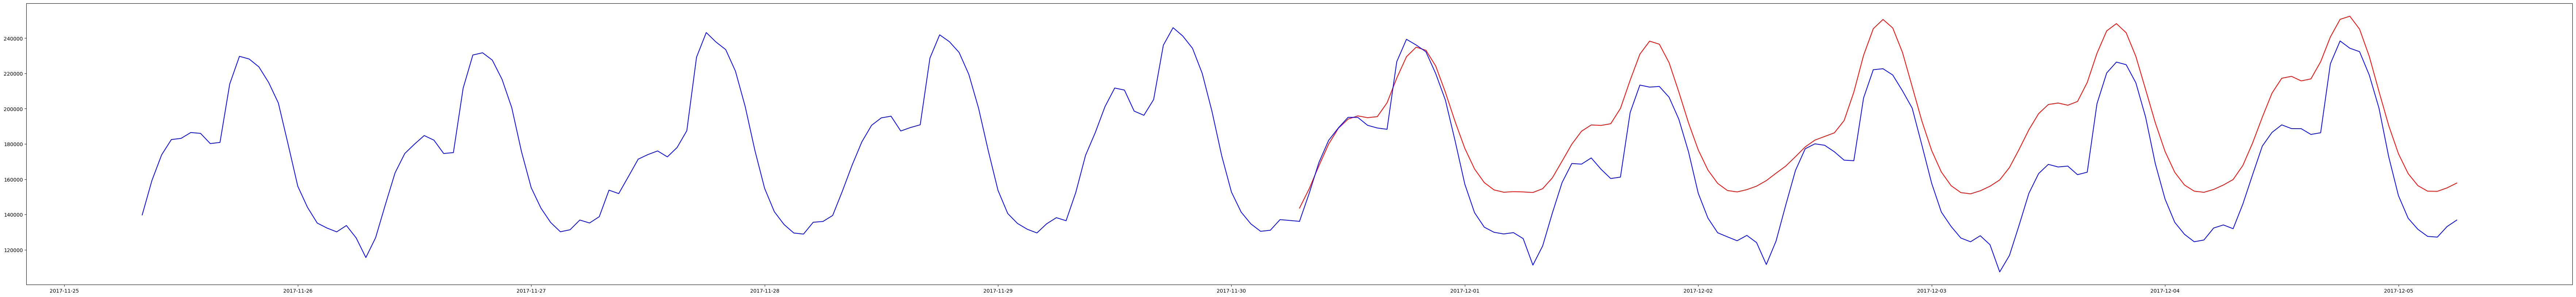

In [ ]:
Hop = df.loc[:,'Power Cons.']

plotFreq = "1h"  #plotFreq = "30min"

plt.figure(figsize=(90, 10))
plt.plot(Hop[-forecast_period:], color="blue")
plt.plot(pd.date_range(start=df.index[-1], freq= plotFreq, periods=forecast_period), forecast, label='Forecast', color="red")
plt.plot(pd.date_range(start=df.index[-1], freq= plotFreq, periods=forecast_period), temp[:forecast_period], color="blue")

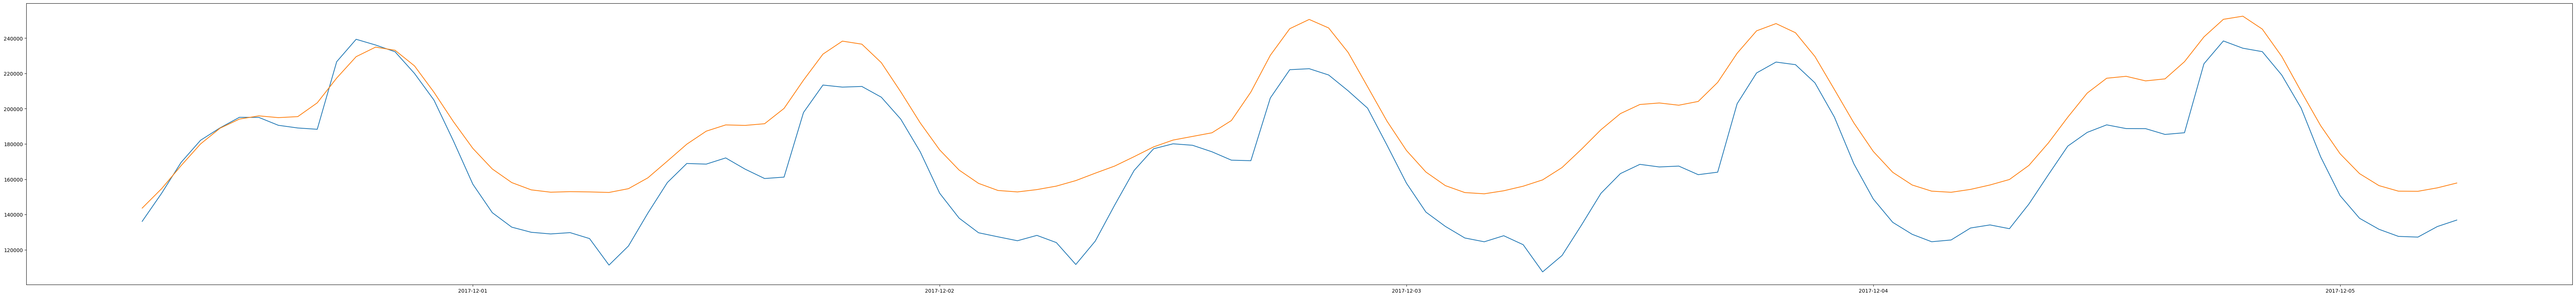

In [ ]:
plt.figure(figsize=(90, 10))

plt.plot(pd.date_range(start=df.index[-1], freq= plotFreq, periods=forecast_period), temp[:forecast_period])
plt.plot(pd.date_range(start=df.index[-1], freq= plotFreq, periods=forecast_period), forecast, label='Forecast')

In [ ]:
forecast = forecast.flatten()
temp1 = temp['Power Cons.'].values
temp1 = temp1[:forecast_period]

ErrorMargin = []
for i in range(len(forecast)):
  ErrorMargin.append(abs(round(100-(forecast[i]*100)/temp1[i],2)))
results = pd.DataFrame(data={'Predictions':forecast, 'Actuals':temp1, 'Error %':ErrorMargin})
results

,Predictions,Actuals,Error %
0,143627,136110,5.52
1,154646,152043,1.71
2,167692,169532,1.09
3,179994,182080,1.15
4,188904,189101,0.10
...,...,...,...
115,156374,131607,18.82
116,153231,127586,20.10
117,153145,127178,20.42
118,155107,133165,16.48
